In [13]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.linalg as linalg

import punct_utils as utils

plt.style.use('default')
plt.rcParams["text.usetex"] = True
np.random.seed(14159)

In [14]:
n = 2000 # sample size
p = 100 # dimension
L = 50 # band size
mu_norm = 5

setting = "$n = {} \\quad p = {} \\quad L = {} \quad || \mu || = {}$".format(n, p, L, mu_norm)

c = p/n
epsilon = (2*L-1)/n

pm1_setting = True

if pm1_setting:
    k = 2 # number of classes
    pi = np.array([0.5, 0.5]) # proportion of each class
    mu = stats.norm.rvs(size=(p, 1))
    M = np.concatenate([+mu, -mu], axis=1)
else:
    k = 3 # number of classes
    pi = np.array([0.34, 0.33, 0.33]) # proportion of each class
    M = stats.norm.rvs(size=(p, k))

M = mu_norm*M/np.linalg.norm(M, axis=0) # centroid of each class
J = utils.getJ(n, pi)
P = M@(J.T)
Z = stats.norm.rvs(size=(p, n))
X = P+Z

K = (X.T@X)/p
T = utils.gen_mask(n, L, kind='toeplitz')

In [15]:
# Make R
chain = np.zeros((5*n, n))

for t in range(chain.shape[0]):
    chain[t] = np.roll(chain[t-1], 1)
    chain[t, 0] = 1
    if np.sum(chain[t]) > L:
        idx_throw = np.random.choice(np.where(chain[t, 1:] == 1)[0])+1
        chain[t, idx_throw] = 0

R = np.zeros((n, n))
for i in range(n):
    R[i, i] = 1
    inter = chain[-n+i, 1:i+1][::-1]
    R[i, :i] = inter
    R[:i, i] = inter

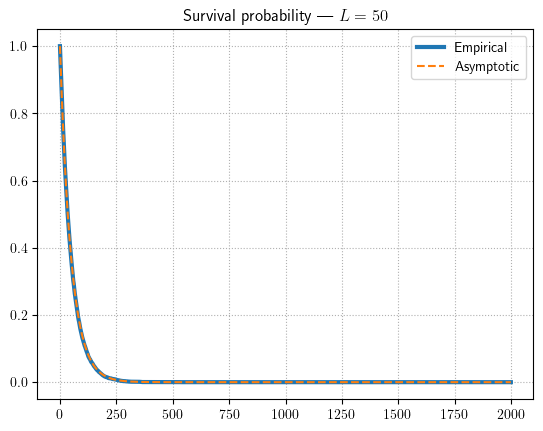

In [16]:
x = np.arange(n)
plt.plot(x, np.mean(chain[n:], axis=0), lw=3, label="Empirical")
plt.plot(x, np.exp(-x/L), ls='--', label="Asymptotic")
plt.grid(ls=':')
plt.legend()
plt.title("Survival probability | $L = {}$".format(L))
plt.show()

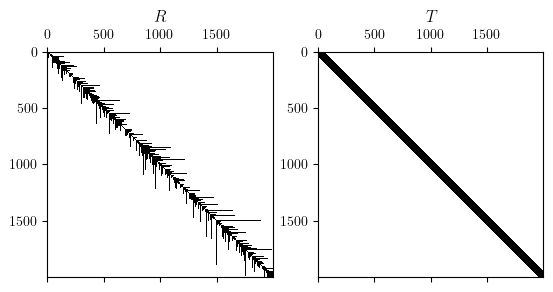

In [17]:
fig, ax = plt.subplots(1, 2)
ax[0].matshow(R, cmap='binary')
ax[0].set_title("$R$")
ax[1].matshow(T, cmap='binary')
ax[1].set_title("$T$")
plt.show()

In [18]:
eigvals, eigvecs = linalg.eigh(R)

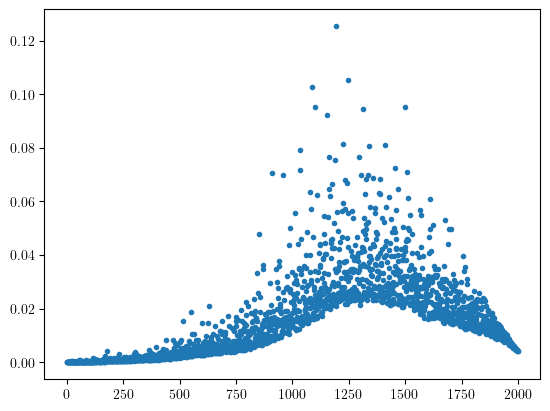

In [19]:
plt.plot(eigvecs[:, -1], ls='', marker='.')
plt.show()

In [20]:
eigvals_r, eigvecs_r = linalg.eigh(K*R)
eigvals_t, eigvecs_t = linalg.eigh(K*T)
IPR_r = np.sum(eigvecs_r**4, axis=0)/(np.sum(eigvecs_r**2, axis=0)**2)
IPR_t = np.sum(eigvecs_t**4, axis=0)/(np.sum(eigvecs_t**2, axis=0)**2)

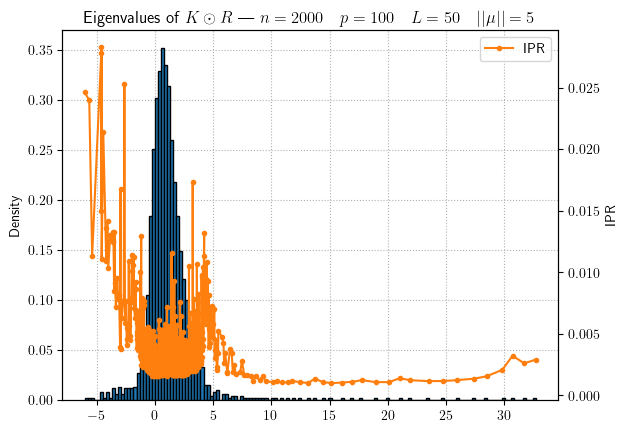

In [21]:
plt.hist(eigvals_r, density=True, color='C0', bins='auto', edgecolor='black', zorder=3)
plt.ylabel("Density")
plt.grid(ls=':')
ax1 = plt.gca()
ax2 = plt.twinx()
plt.plot(eigvals_r, IPR_r, color='C1', marker='.', label="IPR")
plt.ylabel("IPR")
plt.legend()
plt.title("Eigenvalues of $K \odot R$ | "+setting)
plt.show()

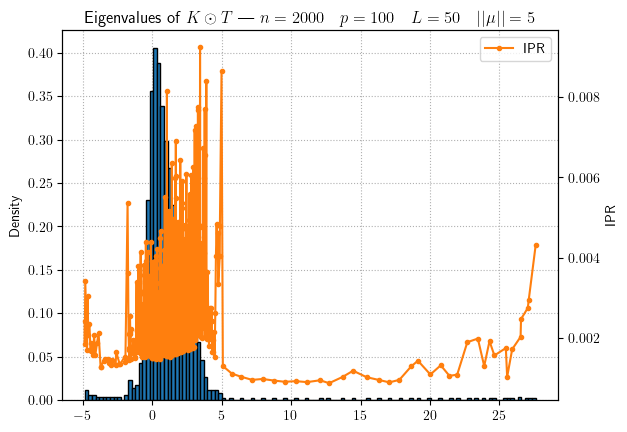

In [22]:
plt.hist(eigvals_t, density=True, color='C0', bins='auto', edgecolor='black', zorder=3)
plt.ylabel("Density")
plt.grid(ls=':')
ax1 = plt.gca()
ax2 = plt.twinx()
plt.plot(eigvals_t, IPR_t, color='C1', marker='.', label="IPR")
plt.ylabel("IPR")
plt.legend()
plt.title("Eigenvalues of $K \odot T$ | "+setting)
plt.show()

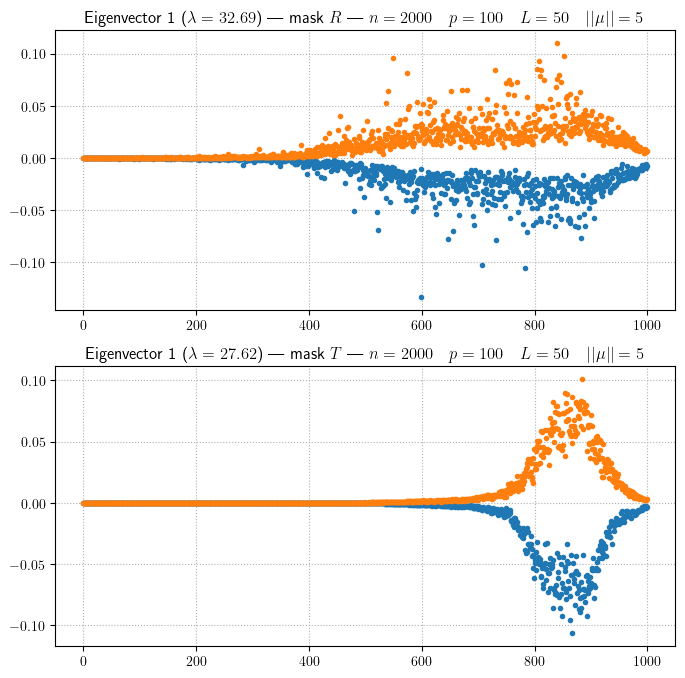

In [23]:
idx = -1
fig, ax = plt.subplots(2, 1, figsize=(8, 8))
for j in range(k):
    ax[0].plot(eigvecs_r[J[:, j] == 1, idx], marker='.', ls='', label="Class {}".format(j+1))
    ax[1].plot(eigvecs_t[J[:, j] == 1, idx], marker='.', ls='', label="Class {}".format(j+1))
ax[0].grid(ls=':')
ax[1].grid(ls=':')
ax[0].set_title("Eigenvector {} ($\\lambda = {}$) | mask $R$ | ".format(-idx, np.round(eigvals_r[idx], 2))+setting)
ax[1].set_title("Eigenvector {} ($\\lambda = {}$) | mask $T$ | ".format(-idx, np.round(eigvals_t[idx], 2))+setting)
plt.show()